In [1]:
import numpy as np
from scipy.optimize import fsolve

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from matplotlib.offsetbox import AnchoredText
from matplotlib.animation import FuncAnimation
from functools import partial

from ipywidgets import interact, FloatSlider, IntSlider
from IPython.display import display
from ipywidgets import HBox, VBox, Layout, widgets

from sympy import solve, diff, symbols, Matrix, Symbol
import sympy.core.numbers as spn

from typing import List, Union, Tuple
import time

# configuration for saving animations. This path points to the ffmpeg executable
mpl.rcParams['animation.ffmpeg_path'] = 'C:\\Program Files\\FFmpeg\\bin\\ffmpeg.exe'

# interactive plots
%matplotlib widget

<h1> 7 Chaos </h1>
<h2> 7.1 Continuous time </h2>
<h3> 7.1.1 Simulate chaos </h3>

In [2]:
"""General functions"""


def euler_int(start, f, dt, steps, *args, **kwargs):
    """
    function implementing the euler method for integrating a function with N variables
    """
    eul = np.zeros((steps, len(start)))
    eul[0] = start
    
    for i in range(steps-1):
        eul[i+1] = eul[i] + dt * f(*eul[i], *args, n=i, **kwargs)
    
    return eul.T # return the transpose so we can use X, Y, Z = euler_int( ... )


def get_color_range(N, c_map_name):
    """
    create a range of N discrete colors from a matplotlib colormap
    """
    cmap = cm.get_cmap(c_map_name)
    return [cmap(i) for i in np.linspace(0, 1, N)]


class Markup:
    RED = '\033[91m'
    GREEN = '\033[92m'
    B = '\033[1m'
    U = '\033[4m'
    END = '\033[0m'

    @staticmethod
    def b_red(s: str) -> str:
        return Markup.B + Markup.RED + s + Markup.END

    @staticmethod
    def b_green(s: str) -> str:
        return Markup.B + Markup.GREEN + s + Markup.END

    @staticmethod
    def bold(s: str) -> str:
        return Markup.B + s + Markup.END

In [3]:
"""Food chain model functions"""


def food_chain_model(X, Y, Z, a1, a2, b1, b2, d1, d2, *args, **kwargs):
    def X_prime(X, Y, a1, b1):
        return X*(1-X) - a1*X*Y / (1 + b1*X)
    
    def Y_prime(X, Y, Z, a1, a2, b1, b2, d1):
        return a1*X*Y / (1 + b1*X) - d1*Y - a2*Y*Z / (1 + b2*Y)
    
    def Z_prime(Y, Z, a2, b2, d2):
        return a2*Y*Z / (1 + b2*Y) - d2*Z
    
    return np.array([X_prime(X, Y, a1, b1),
                     Y_prime(X, Y, Z, a1, a2, b1, b2, d1),
                     Z_prime(Y, Z, a2, b2, d2)])


def plot_food(ax_traject, ax_time, start, constants, cutoff=0, dt=0.01, nsteps=100000):
    cmap = get_color_range(len(start), 'autumn')
    alpha = 1/len(start)
    for n, i in enumerate(start):
        X, Y, Z = euler_int(i, food_chain_model, dt, nsteps, **constants)
        
        ax_traject.plot(X[cutoff:], Y[cutoff:], Z[cutoff:], color=cmap[n], label='(X, Y, Z) = ({:.2f}, {:.2f}, {:.2f})'.format(*i), alpha=alpha)
        ax_traject.set_xlabel('X'), ax_traject.set_ylabel('Y'), ax_traject.set_zlabel('Z')
        
        if ax_time:
            time = np.array(range(nsteps))
            ax_time.plot(time, X, c='red', alpha=alpha)
            ax_time.plot(time, Y, c='blue', alpha=alpha)
            ax_time.plot(time, Z, c='green', alpha=alpha)

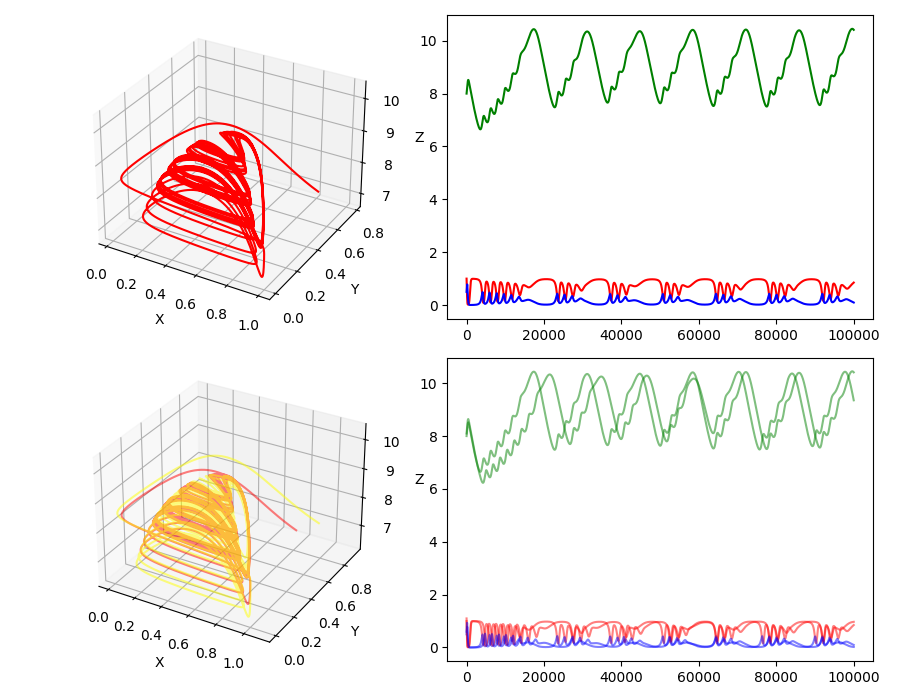

In [4]:
start = [(1.0, 0.5, 8.0), (1.1, 0.6, 8.1)]
constants = {'a1': 5, 'b1': 3, 'a2': 0.1, 'b2': 2, 'd1': 0.4, 'd2': 0.01}
f1 = plt.figure(figsize=(9, 7))
ax1 = f1.add_subplot(221, projection='3d')
ax2 = f1.add_subplot(222)
ax3 = f1.add_subplot(223, projection='3d')
ax4 = f1.add_subplot(224)
plot_food(ax1, ax2, [start[0]], constants)
plot_food(ax3, ax4, start, constants)
f1.tight_layout()
plt.show()

In [5]:
"""Calculating distance"""


distance = np.sqrt(np.sum(np.fromiter(((start[0][i] - start[1][i])**2 for i in range(3)), dtype=float)))
print('distance between ({:.2f}, {:.2f}, {:.2f}) and ({:.2f}, {:.2f}, {:.2f}) is {:.5f}'.format(*start[0], *start[1], distance))

distance between (1.00, 0.50, 8.00) and (1.10, 0.60, 8.10) is 0.17321


<h3> 7.1.2 Transition to chaos </h3>

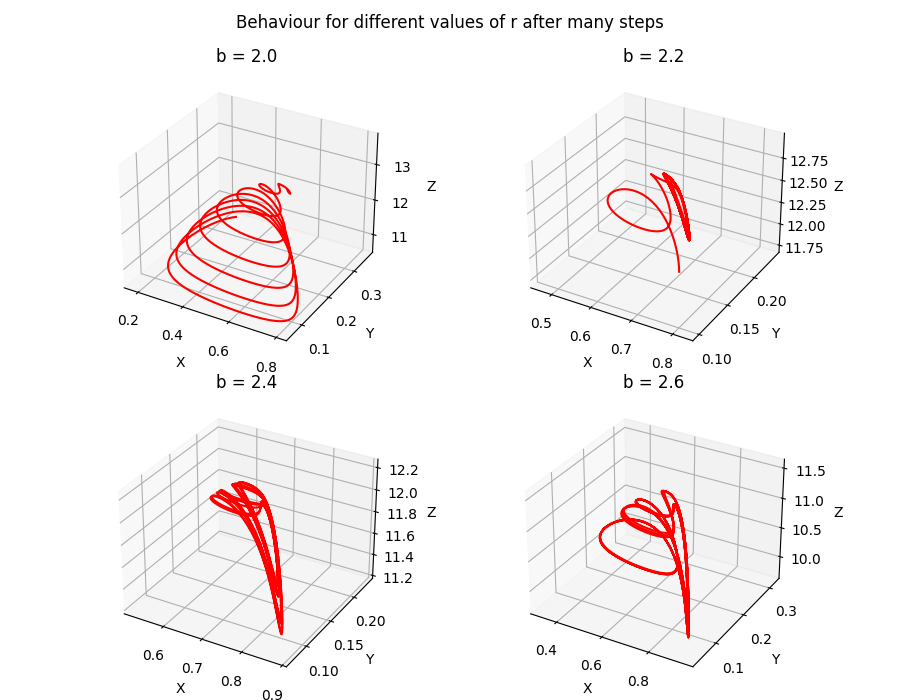

In [6]:
"""Varying b1"""


f2 = plt.figure(figsize=(9, 7))
for n, b in enumerate(range(20, 28, 2)):
    ax = f2.add_subplot(221 + n, projection='3d')
    constants['b1'] = b / 10
    plot_food(ax, None, [start[0]], constants, cutoff=25000)
    ax.set_title(f'b = {b / 10}')

f2.suptitle('Behaviour for different values of r after many steps')
f2.tight_layout()
plt.show()

<h2> 7.2 Discrete time </h2>

In [7]:
"""Constants"""
X_n = np.linspace(0, 1, 100)

In [8]:
"""Functions"""


def eq(x, r, *args, **kwargs):
    return np.array([r*x*(1-x)])

In [9]:
def add_max_text(ax, X_n1):
    at = AnchoredText(f'max = {np.max(X_n1):.2f}', frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    return ax.add_artist(at)


def plot_r_line(ax, it, title, add_text=False):
    clist = get_color_range(len(it), 'inferno') if len(it) > 1 else ['red']
    for n, r_ in enumerate(it):
        line, = ax.plot(X_n, eq(X_n, r_)[0], c=clist[n], label=f'$r={r_:.1f}$')
        
    ax.set_xlabel('$X_n$')
    ax.set_ylabel('$X_{n+1}$')
    ax.set_title(title)
    return line, add_max_text(ax, X_n) if add_text else line

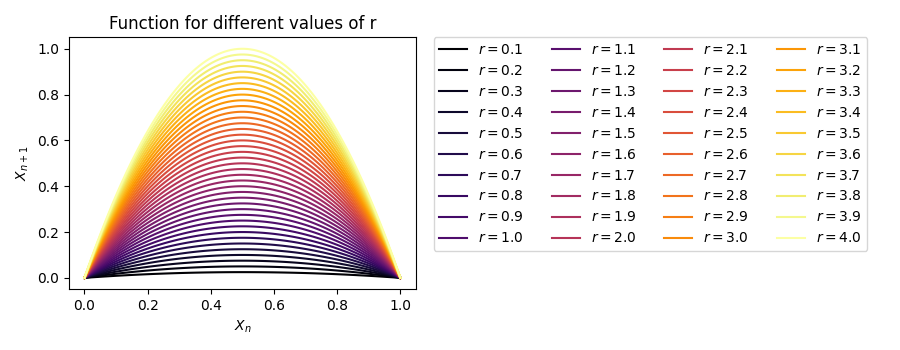

In [10]:
"""Plotting question 1"""
f3 = plt.figure(figsize=(9, 3.5))
ax3 = f3.add_subplot()
plot_r_line(ax3, np.array(range(1, 41, 1)) / 10, 'Function for different values of r')

ax3.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0., ncol=4)
f3.tight_layout()
plt.show()

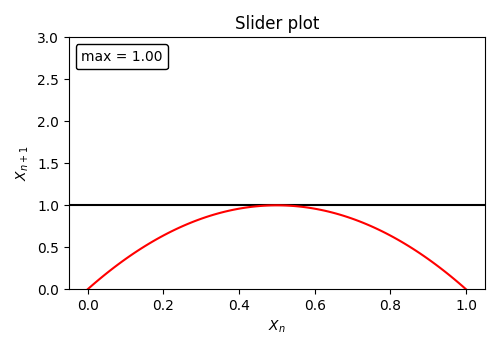

In [11]:
"""Plotting question 1 with widgets"""
f4 = plt.figure(figsize=(5, 3.5))
ax4 = f4.add_subplot()
ax4.axhline(1, -1, 2, c='black')
ax4.set_ylim(0, 3)

global text
line, text = plot_r_line(ax4, [4], 'Slider plot', add_text=True)
f4.tight_layout()


def update_plot(r_new):
    X_n1 = eq(X_n, r_new)[0]
    line.set_ydata(X_n1)
    
    global text
    text.remove()
    text = add_max_text(ax4, X_n1)


def on_slider_change(source):
    value = source['new']
    update_plot(value)


# Create slider
slider = widgets.FloatSlider(description=r"$r$", min=0, max=10, step=0.1, value=4, continuous_update=True)
slider.observe(on_slider_change, names='value')
HBox([slider])

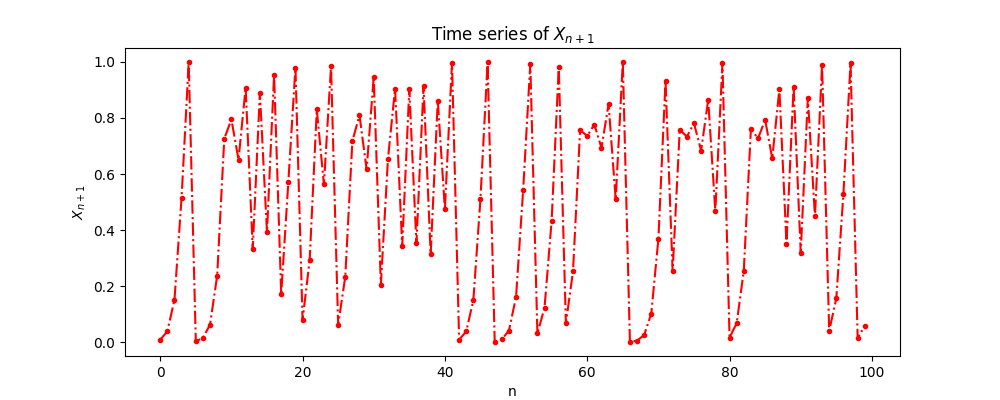

After 100 steps we find a value of:
X_n+1 = 0.059586012685578525


In [12]:
"""Plotting question 2"""

def time_series(start, f, steps, *args, **kwargs):
    time = np.zeros((steps, len(start)))
    time[0] = start
    for i in range(steps-1):
        time[i+1] = f(*time[i], *args, **kwargs)
    return time.T # return the transposed array so we can use X, Y, Z = euler_int( ... )


def plot_time_series(ax, start, l, r, c='red', style='-.', marker='.'):
    x, = time_series(start, eq, l, r)
    t = np.array(range(l))
    
    time, = ax.plot(t, x, label=r'$x_0$={}'.format(start[0]), linestyle=style, marker=marker, c=c)
    ax.set_ylabel(r'$X_{n+1}$')
    ax.set_xlabel('n')
    ax.set_title('Time series of $X_{n+1}$')
    return time, x


f5 = plt.figure(figsize=(10, 4.))
ax5 = f5.add_subplot()
_, x = plot_time_series(ax5, [0.01], 100, 4)
plt.show()

print(f'After 100 steps we find a value of:\n{Markup.bold("X_n+1 = " + str(x[-1]))}')

interactive(children=(FloatSlider(value=0.1, description='$X_0$', max=1.0, min=0.1), FloatSlider(value=4.0, de…

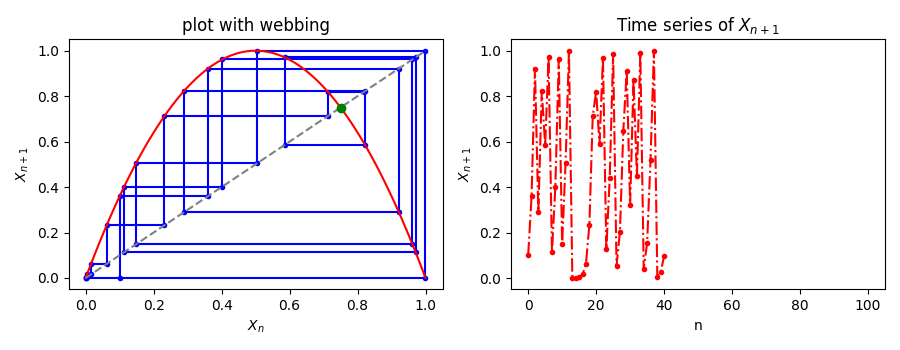

In [13]:
r_init = 4
l_init = 41
x0_init = 0.1


def cobwebbing(X_0, steps, r=4):
    x, y = np.zeros((2, steps))
    x[0], y[0] = X_0, 0
    for i in range(0, steps-1, 2):
        x[i+1], y[i+1] = x[i], eq(x[i], r)
        x[i+2], y[i+2] = y[i+1], y[i+1]
    return x, y


def eq_point(r):
    return (r-1) / r


# init plots
f6, axes6 = plt.subplots(nrows=1, ncols=2, figsize=(9, 3.5))

# plot cobwebbing
x, y = cobwebbing(x0_init, steps=l_init, r=r_init)
web, = axes6[0].plot(x, y, c='blue', marker='.', label='Cobweb')

# plot lines
line, _ = plot_r_line(axes6[0], [r_init], 'plot with webbing')
b = np.linspace(0, 1, 100)
axes6[0].plot(b, b, c='grey', linestyle='--')

# plot equilibrium
equi = eq_point(r_init)
equilibrium, = axes6[0].plot(equi, equi, marker='o', c='green', label='Equilibrium')

# plot time series
time_, _ = plot_time_series(axes6[1], [x0_init], l_init, r_init)
axes6[1].set_xlim(-5, 105)

# init sliders
slider_r = widgets.FloatSlider(description=r'$r$', min=0.1, max=4, step=0.1, value=r_init)
slider_l = widgets.IntSlider(description=r'$steps$', min=3, max=101, step=2, value=l_init)
slider_start = widgets.FloatSlider(description=r'$X_0$', min=0.1, max=1, step=0.1, value=x0_init)


@interact(X_0=slider_start, r=slider_r, l=slider_l)
def update_web(X_0=0.1, r=4, l=101):
    # update the line
    X_n1 = eq(X_n, r)[0]
    line.set_ydata(X_n1)
    
    # update the web
    x, y = cobwebbing(X_0, steps=l, r=r)
    web.set_xdata(x)
    web.set_ydata(y)
    
    # update equilibrium point
    equi = eq_point(r)
    equilibrium.set_xdata(equi)
    equilibrium.set_ydata(equi)
    
    # update time series
    x, = time_series([X_0], eq, l, r)
    t = np.array(range(l))
    time_.set_xdata(t)
    time_.set_ydata(x)
    
    f6.canvas.draw()
    f6.canvas.flush_events()

    
f6.tight_layout()

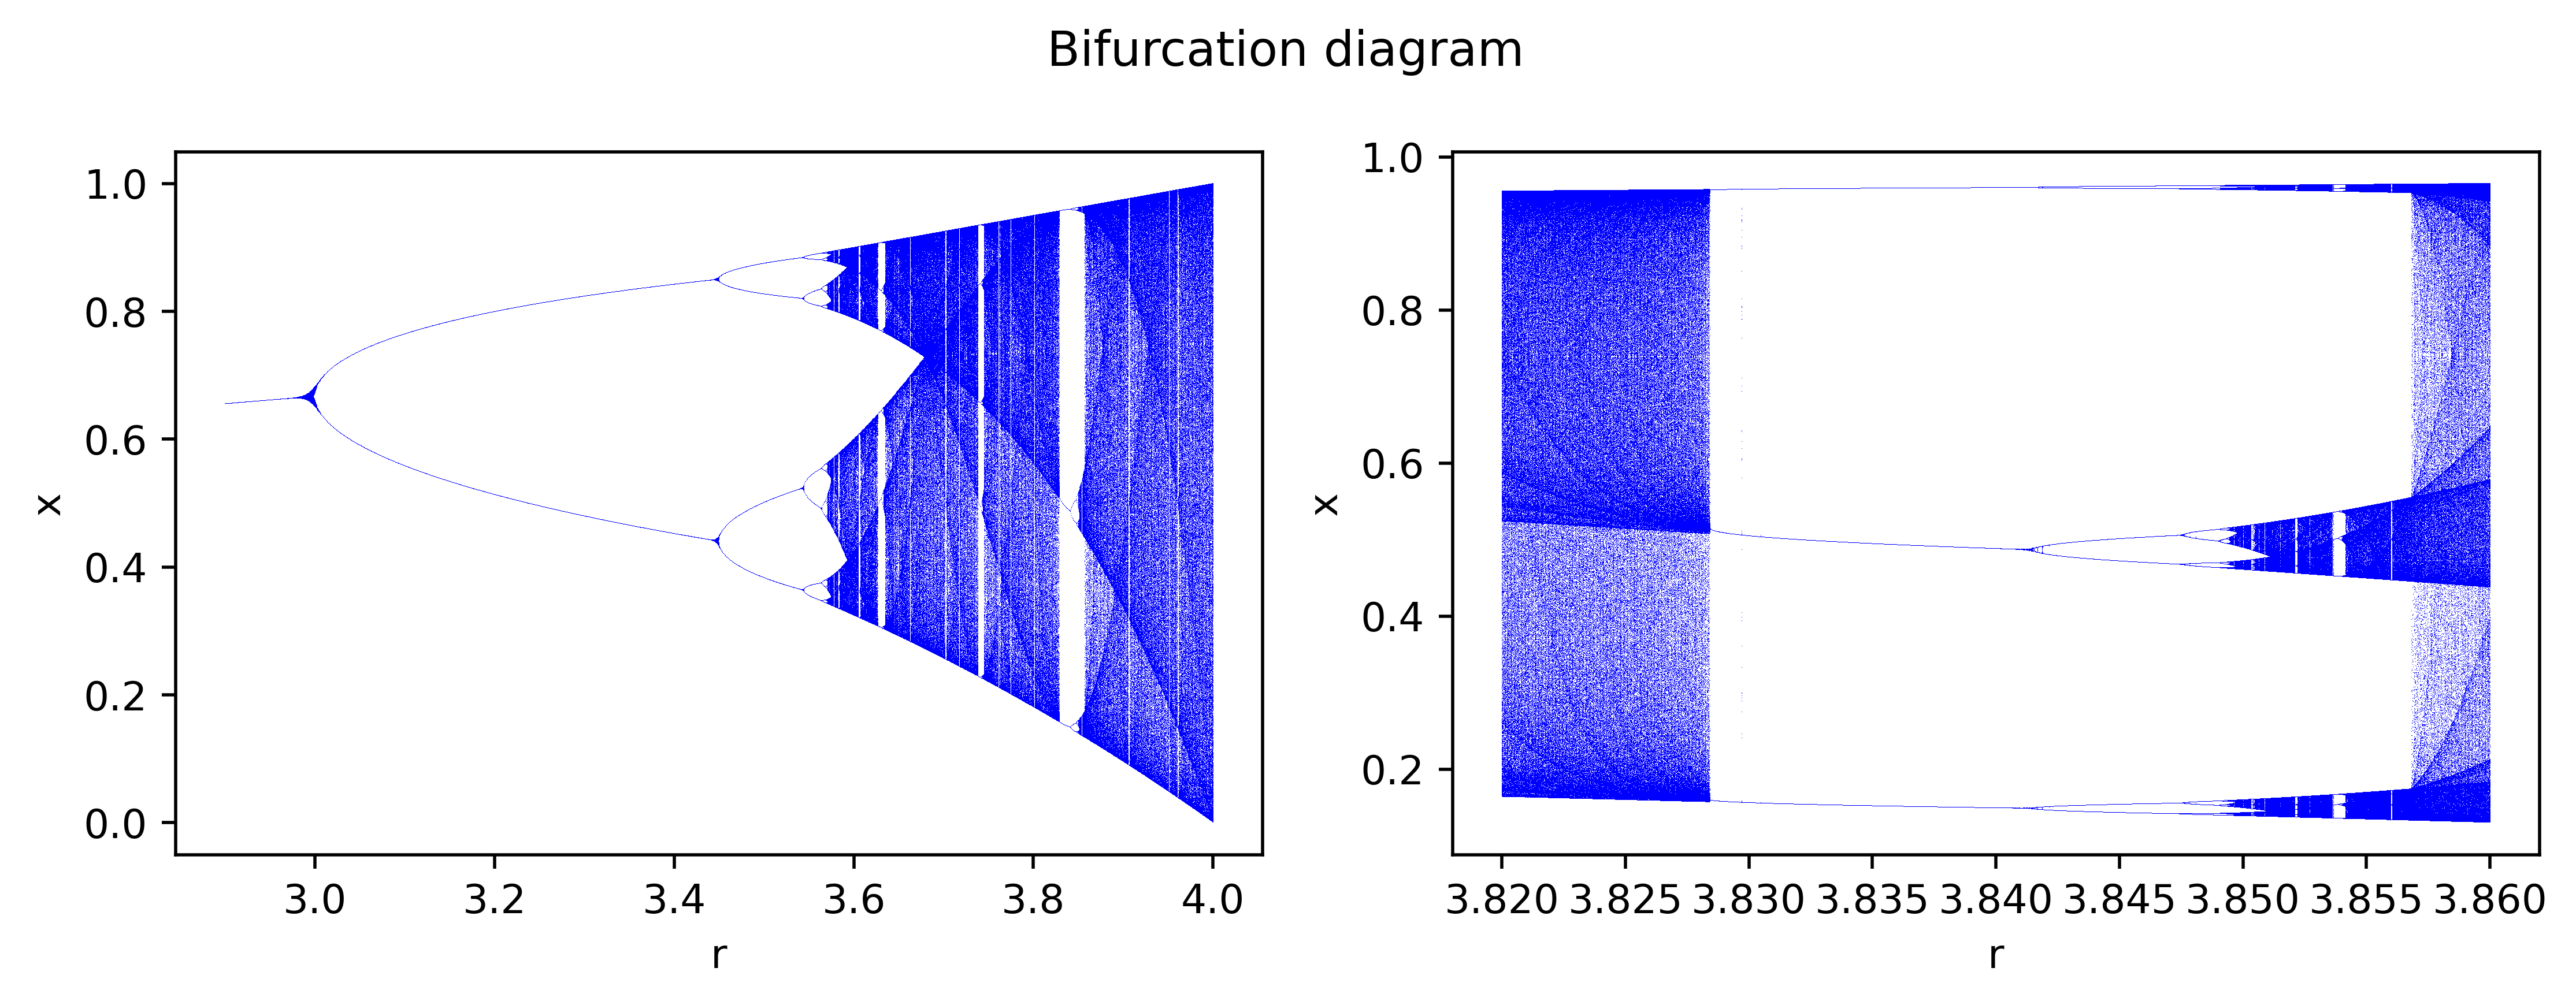

In [14]:
"""Bifurcation diagram"""


def calc_bifurcation(r_min, r_max, len_r=2001, len_x=1501):
    it_r = np.linspace(r_min, r_max, len_r)
    x_vals = np.zeros((len_r, len_x))
    y_vals = np.zeros((len_r, len_x))
    for n, r_ in enumerate(it_r):
        print('calculating slice {}/{}'.format(n, len_r - 1), end="\r")
        y, = time_series([0.1], eq, len_x + 200, r_)
        x_vals[n] = np.full(len_x, r_)
        y_vals[n] = y[200:]
    return x_vals.flatten(), y_vals.flatten()
    

def plot_bifurcation(ax, r_min, r_max):
    x, y = calc_bifurcation(r_min, r_max)
    ax.plot(x, y, c='blue', linestyle='None', marker=',')
    ax.set_xlabel('r')
    ax.set_ylabel('x')

    
f7, axes7 = plt.subplots(nrows=1, ncols=2, figsize=(9, 3.5), dpi=500)

# plot for different zooms
plot_bifurcation(axes7[0], 2.9, 4)
plot_bifurcation(axes7[1], 3.82, 3.86)

f7.suptitle('Bifurcation diagram')
f7.tight_layout()

# use special display function and cancel the display by %matplotlib widget because this
# gives weird results with the higher dpi
display(f7)
plt.close()

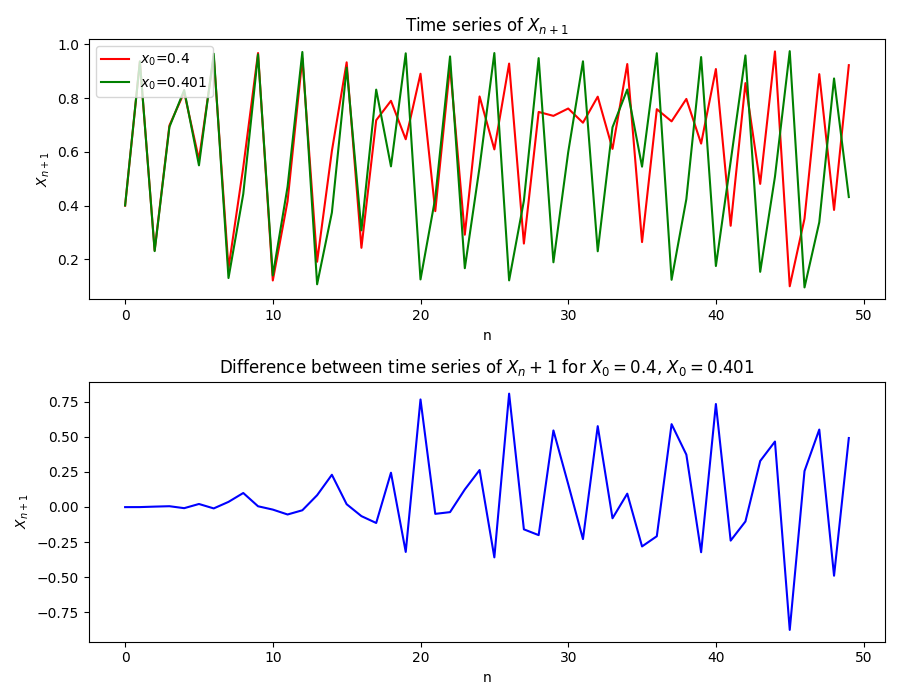

In [15]:
"""Hallmarks of chaos"""
def plot_time_series_diff(ax1, ax2, start, l, r):
    _, x1 = plot_time_series(ax1, [start[0]], 50, 3.9, c='red', style='-', marker=None)
    _, x2 = plot_time_series(ax1, [start[1]], 50, 3.9, c='green', style='-', marker=None)
    ax1.legend(loc='upper left')
    t = np.array(range(l))
    
    time, = ax2.plot(t, x1 - x2, c='blue')
    ax2.set_ylabel(r'$X_{n+1}$')
    ax2.set_xlabel('n')
    ax2.set_title(r'Difference between time series of $X_{}$ for $X_0 = {}$, $X_0 = {}$'.format('n+1', *start))


f8, axes8 = plt.subplots(nrows=2, ncols=1, figsize=(9, 7))
plot_time_series_diff(*axes8, [0.4, 0.401], 50, 3.9)
f8.tight_layout()

<h2> 7.3 Randomness versus chaos </h2>
<h3> 7.3.1 The logistic equation </h3>

In [16]:
def f1(X):
    return np.array([4*X*(1-X)])


def make_poincarre(ax, array, title):
    pointcarre, = ax.plot(array[:-1], array[1:],
                          marker='.', linestyle='None', color='black', alpha=.1,
                          label='$X_{n+1} = X_N \cdot (1 - X_N)$')
    ax.set_title(title)
    ax.set_xlabel('$V_N$')
    ax.set_ylabel('$V_{N+1}$')
    return pointcarre

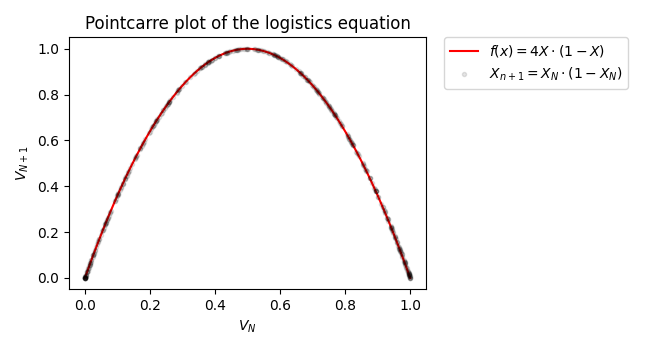

In [17]:
x_, = time_series([0.4], eq, 400, r=4)

X1 = np.linspace(0, 1, 400)
f1_X = f1(X1)[0]

f9, axes9 = plt.subplots(nrows=1, ncols=1, figsize=(6.5, 3.5))
axes9.plot(X1, f1_X, color='red', zorder=1, label=f'$f(x) = 4X \cdot (1-X)$')
make_poincarre(axes9, x_, 'Pointcarre plot of the logistics equation')
axes9.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)
f9.tight_layout()
plt.show()

<h3> 7.3.2 The FHN model </h3>

In [18]:
def calc_I_ext(n, I_ext, p, d):
    return I_ext if (n - (n // p)*p) < d else 0


def FHN_model(V, w, I_ext, p, d, n, a=0.1, e=0.008, gamma=0.5):
    def V_Prime(V, w, a, e, gamma, I_ext):
        return (1 / e)*(-w + V*(1 - V)*(V - a) + calc_I_ext(n, I_ext, p, d))
    
    def w_Prime(V, w, gamma):
        return V - gamma*w
    
    return np.array([V_Prime(V, w, a, e, gamma, I_ext), w_Prime(V, w, gamma)])

In [19]:
def calc_FHN_data(n_steps, I_ext, p, d, phase=0):
    # calculate the values for V, w and the time
    v, w = euler_int((0, 0), FHN_model, 0.01, n_steps, I_ext=I_ext, p=p, d=d)
    t = np.array(range(len(v)))
    
    # calculate the periodic values for the pointcarre plot
    v_ = v[phase::p]
    t_ = t[phase::p]
    
    # Calculate the max value of each period
    max_array = np.array([np.max(v[i*p:(i+1)*p]) for i in range(len(v) // p)])
    return (v, w, t), (v_, t_), max_array


def plot_FHN(axes, n_steps, I_ext, p, d):
    (v, w, t), (v_, t_), max_array = calc_FHN_data(n_steps, I_ext, p, d)
    
    # plot the time series
    line1, = axes[0].plot(t, v, c='blue', label='$I_{ext} = 0.01$')
    axes[0].set_xlabel('t'), axes[0].set_ylabel('V')
    axes[0].set_title('Time evolution of pacing train')
    
    # Plot the points of the pointcarre plot on the time series
    line1_pc, = axes[0].plot(t_, v_, marker='.', color='black', linestyle='None')
    
    # Plot the phase plane
    line2, = axes[1].plot(v[300:], w[300:], c='red', label='$I_{ext} = 0.01$')
    axes[1].set_xlabel('V'), axes[1].set_ylabel('w')
    axes[1].set_title('Phase plane')
    
    pc = make_poincarre(axes[2], v_, 'Pointcarre plot')
    max_pc = make_poincarre(axes[3], max_array, 'Maxima')
    
    return line1, line1_pc, line2, pc, max_pc

interactive(children=(IntSlider(value=100, description='Period', max=150, min=5), IntSlider(value=0, descripti…

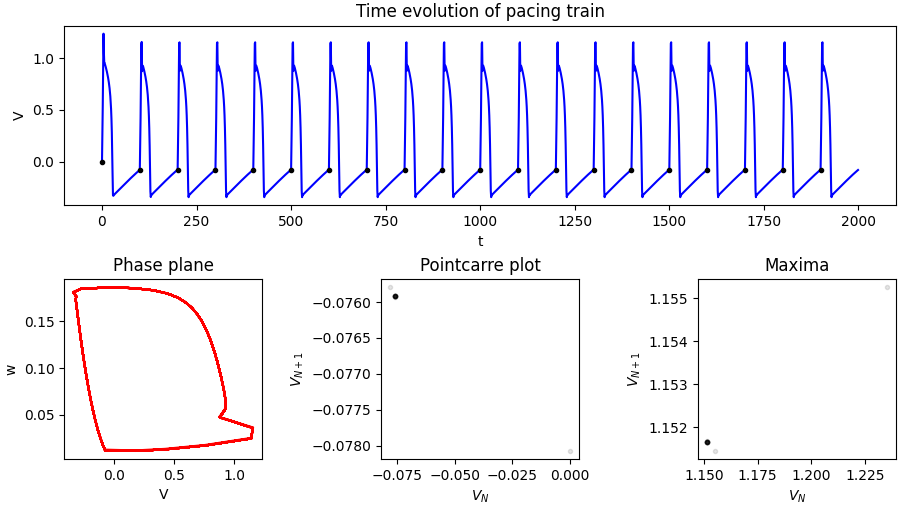

In [21]:
# constants
STEPS = 2000
AMPLITUDE = 0.2
P_INIT = 100
DURATION = 5

# init figure
f10 = plt.figure(figsize=(9, 5.1), constrained_layout=True)

# use GridSpec to divide the figure into subplots
gs = GridSpec(2, 3, figure=f10)
plots = [
    f10.add_subplot(gs[0, :]),
    f10.add_subplot(gs[1, 0]),
    f10.add_subplot(gs[1, 1]),
    f10.add_subplot(gs[1, 2])
]

# create the initial plots
time_line, time_pc, phase_line, pc, max_pc = plot_FHN(plots, STEPS, AMPLITUDE, P_INIT, DURATION)


@interact(Period=(5, 150, 1), Phase=(0, 150, 1))
def update_FHN(Period=P_INIT, Phase=0):
    # Calculate the new data
    (v, w, t), (v_, t_), max_array = calc_FHN_data(STEPS, AMPLITUDE, Period, DURATION, Phase)
    
    # change the data for the time plot and phase plot
    time_line.set_ydata(v)
    phase_line.set_xdata(v[100:])
    phase_line.set_ydata(w[100:])
    
    # Set the new data for the pointcarre plot on the time series plot and pointcarre plot
    pc.set_xdata(v_[:-1])
    pc.set_ydata(v_[1:])
    time_pc.set_xdata(t_)
    time_pc.set_ydata(v_)
    
    # Plot the maxima of the pointcarre plot
    max_pc.set_xdata(max_array[:-1])
    max_pc.set_ydata(max_array[1:])
    
    # recalculate the axis limits for all subplots
    for ax in plots:
        ax.relim()
        ax.autoscale_view()

<h2> 7.4 The Mandelbrot Set </h2>

In [3]:
plot_cst = {
    'size': 1000,
    'max_iter': 50,
    'threshold': 50,
    'cmap_name': 'hsv'
}


brot_cst = {
    'x_min_l': [-2, -1.235, -1.9, -0.34],
    'x_max_l': [1, -1.275, -1.65, -0.26],
    'y_min_l': [-1.5, 0.36, -0.125, -0.685],
    'y_max_l': [1.5, 0.4, 0.125, -0.605],
}

In [4]:
def multibrot(z, c, n=2):
    return np.power(z, n) + c


def calc_fractal(size , x_min, x_max, y_min, y_max, max_iter, threshold, start, func):
    # linspace for both axis of the complex plane
    x = np.linspace(x_min, x_max, size)
    y = np.linspace(y_min, y_max, size)
    
    c = x + y[:, None]*1j
    z_val = np.full(np.shape(c), start, dtype=np.complex64)
    
    # create a new array to put the number of iterations into and the values of z
    n_iter = np.zeros(np.shape(c), dtype=int)
    
    for n in range(max_iter):
        print(f'{n*100/(max_iter-1):.1f}% done, iteration: {n}/{max_iter-1}', end='\r')
        if start == 0:  # mandelbrot algorithm
            I = np.less(abs(z_val), threshold)
            n_iter[I] = n
            z_val[I] = func(z_val[I], c[I])
        else:  # julia algorithm
            I = np.less(abs(c), threshold)
            n_iter[I] = n
            c[I] = func(c[I], z_val[I])
    print(f'{"Done": ^40}', end='\r')
    
    # all values that didn't explode are 0
    n_iter[n_iter == max_iter-1] = 0
    return n_iter


def plot_fractal(ax, x_min, x_max, y_min, y_max, size, max_iter, threshold, cmap_name, start=0, func=multibrot):
    n_iter = calc_fractal(size, x_min, x_max, y_min, y_max, max_iter, threshold, start, func)
    cmap = mpl.cm.get_cmap('hsv')
    img = ax.imshow(n_iter, extent=[x_min, x_max, y_min, y_max], cmap=cmap, norm=LogNorm(vmin=3, vmax=48))
    ax.axis('scaled')
    ax.set_facecolor('black')
    ax.set_xlabel('Real axis')
    ax.set_ylabel('Imaginary axis')

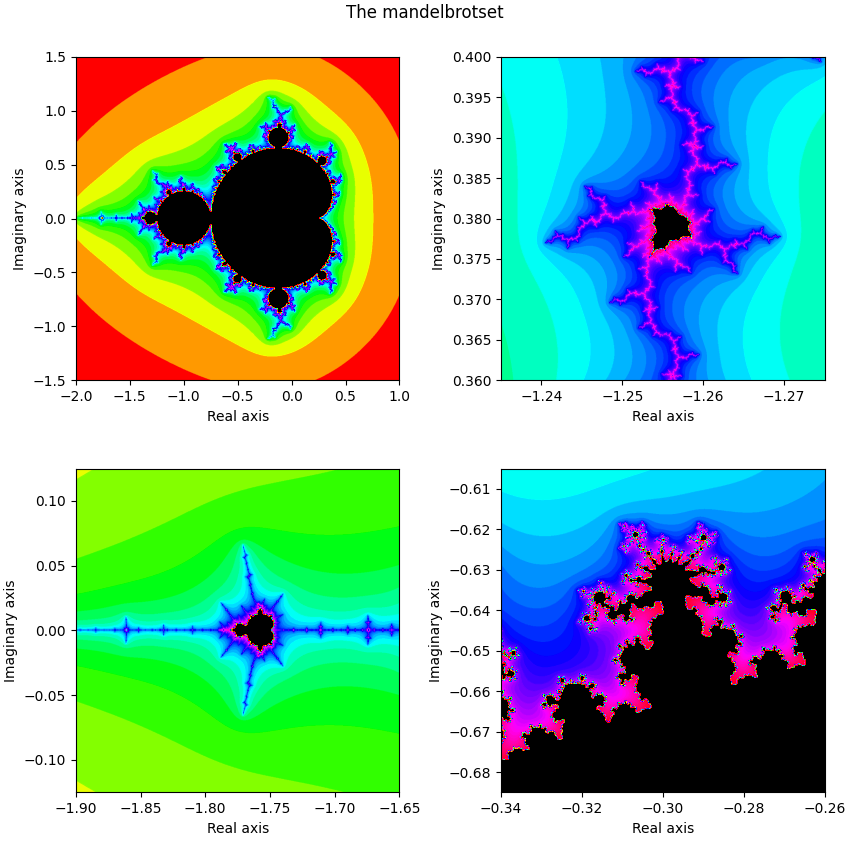

In [5]:
f13, axes13 = plt.subplots(nrows=2, ncols=2, figsize=(8.5, 8.5), constrained_layout=True)
f13.suptitle("The mandelbrotset")
for ax, x_min, x_max, y_min, y_max in zip(axes13.ravel(), *(brot_cst.values())):
    plot_fractal(ax, x_min, x_max, y_min, y_max, **plot_cst)

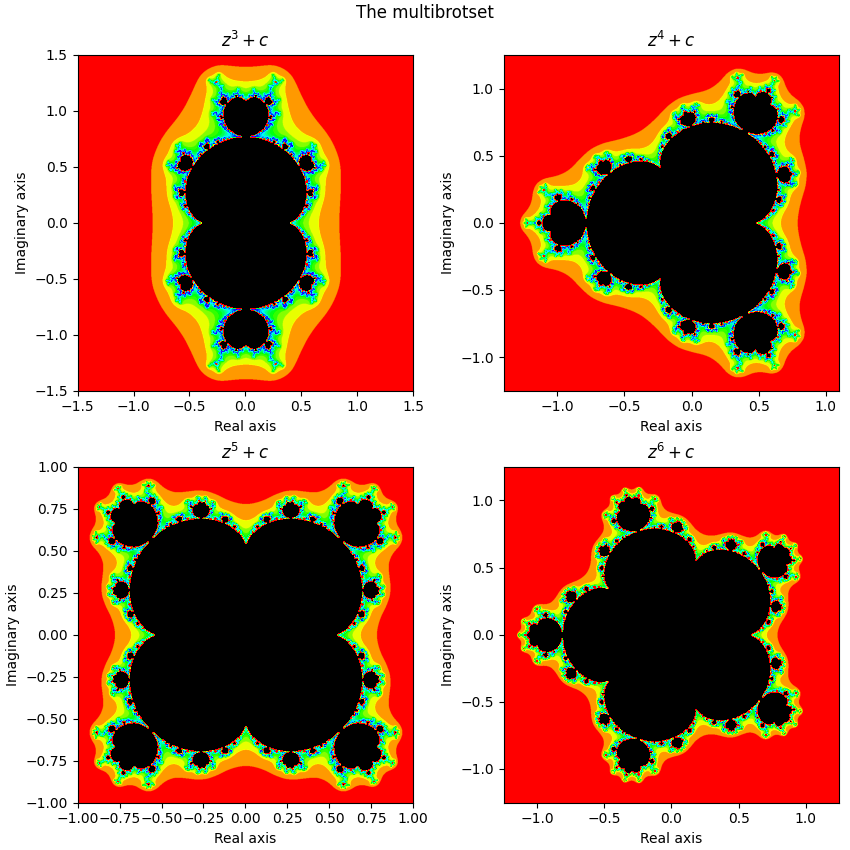

In [6]:
multi_brot_cst = {
    'x_min_l': [-1.5, -1.4, -1, -1.25],
    'x_max_l': [1.5, 1.1, 1, 1.25],
    'y_min_l': [-1.5, -1.25, -1, -1.25],
    'y_max_l': [1.5, 1.25, 1, 1.25],
}

f14, axes14 = plt.subplots(nrows=2, ncols=2, figsize=(8.5, 8.5), constrained_layout=True)
f14.suptitle("The multibrotset")
for n, (ax, x_min, x_max, y_min, y_max) in enumerate(zip(axes14.ravel(), *(multi_brot_cst.values()))):
    plot_fractal(ax, x_min, x_max, y_min, y_max, **plot_cst, func=partial(multibrot, n=n+3))
    ax.set_title('$z^{' + f'{n+3}' + '} + c$')
plt.show()

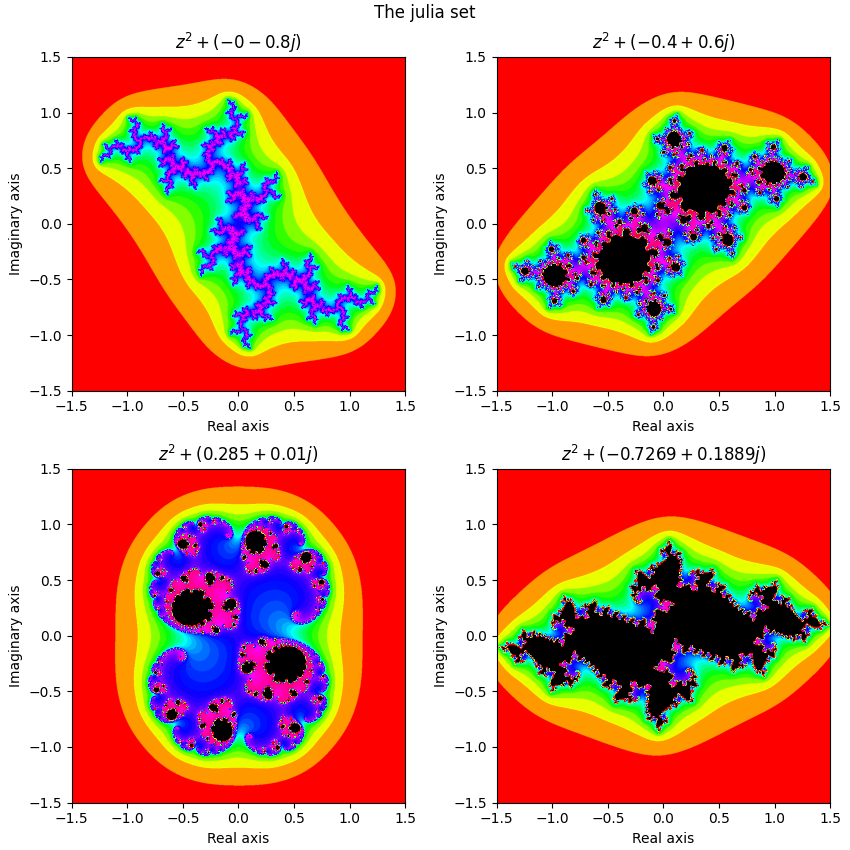

In [7]:
julia_cst = {
    'x_min_l': [-1.5,-1.5, -1.5, -1.5],
    'x_max_l': [1.5, 1.5, 1.5, 1.5],
    'y_min_l': [-1.5,-1.5, -1.5, -1.5],
    'y_max_l': [1.5, 1.5, 1.5, 1.5],
    'cst': [-0.8j, -0.4 + 0.6j, 0.285 + 0.01j, -0.7269 + 0.1889j]
}

f15, axes15 = plt.subplots(nrows=2, ncols=2, figsize=(8.5, 8.5), constrained_layout=True)
f15.suptitle("The julia set")
for n, (ax, x_min, x_max, y_min, y_max, c) in enumerate(zip(axes15.ravel(), *(julia_cst.values()))):
    plot_fractal(ax, x_min, x_max, y_min, y_max, **plot_cst, start=c)
    ax.set_title(f'$z^2 + {c}$')

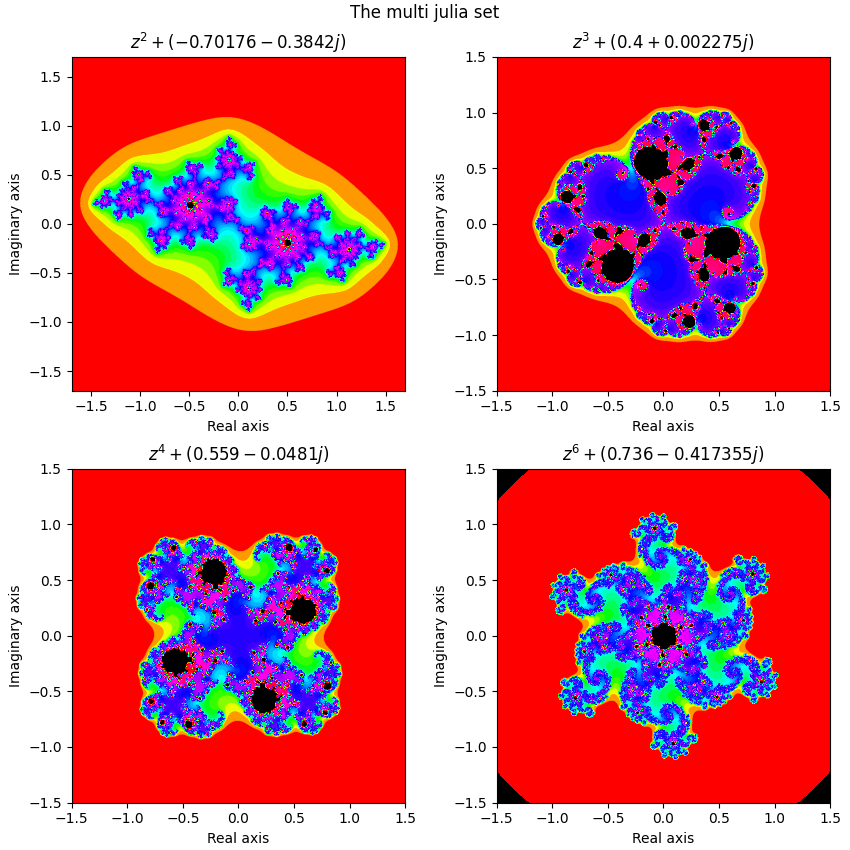

In [8]:
multi_julia_cst = {
    'x_min_l': [-1.7,-1.5, -1.5, -1.5],
    'x_max_l': [1.7, 1.5, 1.5, 1.5],
    'y_min_l': [-1.7,-1.5, -1.5, -1.5],
    'y_max_l': [1.7, 1.5, 1.5, 1.5],
    'cst': [-0.70176 - 0.3842j, 0.4 + 0.002275j, 0.559 - 0.0481j, 0.736 - 0.417355j]
}

f16, axes16 = plt.subplots(nrows=2, ncols=2, figsize=(8.5, 8.5), constrained_layout=True)
f16.suptitle("The multi julia set")
powers = [2, 3, 4, 6]
for ax, x_min, x_max, y_min, y_max, c, p in zip(axes16.ravel(), *(multi_julia_cst.values()), powers):
    plot_fractal(ax, x_min, x_max, y_min, y_max, **plot_cst, start=c, func=partial(multibrot, n=p))
    ax.set_title(f'$z^{p} + {c}$')

In [82]:
julia_anim_cst = {
    'size': 2000,
    'max_iter': 50,
    'threshold': 10,
    'x_min': -1.5,
    'x_max': 1.5,
    'y_min': -1.5,
    'y_max': 1.5,
}

# init plots
f17, axes17 = plt.subplots(nrows=1, ncols=1, figsize=(5, 4.5))

# Determine the middle of the spiral
z = calc_fractal(**julia_anim_cst, start=1+0j, func=multibrot)
cmap = mpl.cm.get_cmap('hsv')
cst_space = np.linspace(0, 2*np.pi, 362)
img = axes17.imshow(z, extent=[-1.5, 1.5, -1.5, 1.5], cmap=cmap, norm=LogNorm(vmin=3, vmax=48))
f17.suptitle(r'Animation of the julia set for $z = 0.7885 \cdot e^{i \theta}$ with $\theta \in [0, 2\pi]$')
axes17.axis('scaled')
axes17.set_facecolor('black')
axes17.set_xlabel('Real axis')
axes17.set_ylabel('Imaginary axis')

def animate(i):
    cst = 0.7885*np.exp(1j*cst_space[i+1])
    new_z = calc_fractal(**julia_anim_cst, start=cst, func=multibrot)
    img.set_data(new_z)
    return f17,


# start an animation
anim = FuncAnimation(f17, animate, interval=20, frames=360, blit=True, repeat=False)

# uncomment this code if you want to save the animation
try:
    anim.save("Animation_julia_set.mp4", writer='ffmpeg', fps=20, dpi=500)
except Exception as e:
    print(e)
    print('Saving of the animation failed.')
    
plt.close(f17)

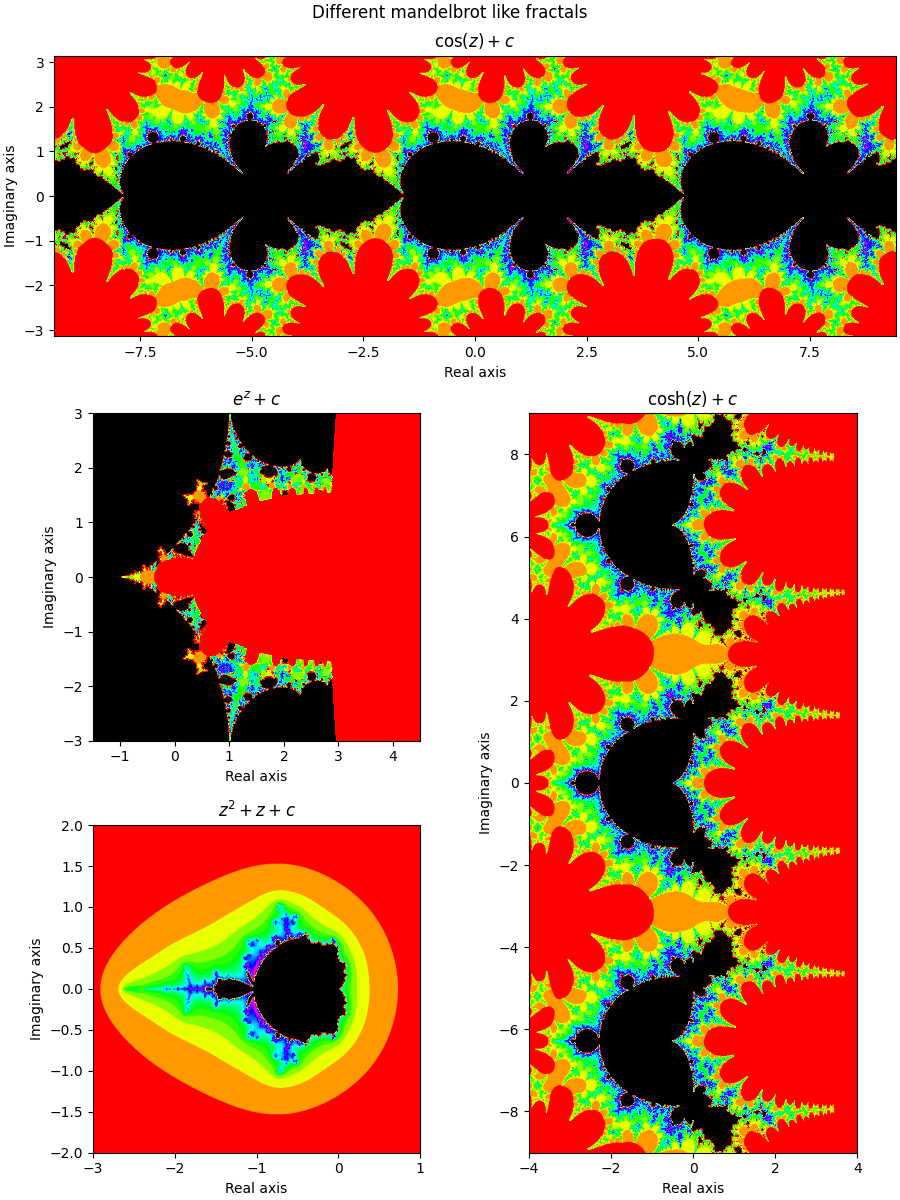

In [111]:
def cos(z, c):
    return np.cos(z) + c

def cosh(z, c):
    return np.cosh(z) + c


def exp(z, c):
    return np.exp(z) + c


def poly(z, c):
    return z**2 + z + c


variations_cst = {
    'x_min_l': [-3*np.pi, -1.5, -4, -3],
    'x_max_l': [3*np.pi, 4.5, 4, 1],
    'y_min_l': [-np.pi, -3, -9, -2],
    'y_max_l': [np.pi, 3, 9, 2],
    'titles': [r'$\cos(z) + c$', r'$e^z + c$', r'$\cosh(z) + c$', r'$z^2 + z + c$']
}

# init figure
f18 = plt.figure(figsize=(9, 12), constrained_layout=True)

# use GridSpec to divide the figure into subplots
gs = GridSpec(3, 2, figure=f18)
plots = [
    f18.add_subplot(gs[0, :]),
    f18.add_subplot(gs[1, :-1]),
    f18.add_subplot(gs[1:, -1]),
    f18.add_subplot(gs[-1, 0])
]

f18.suptitle("Different mandelbrot like fractals")
funcs = [cos, exp, cosh, poly]
for ax, f, x_min, x_max, y_min, y_max, title in zip(plots, funcs, *(variations_cst.values())):
    plot_fractal(ax, x_min, x_max, y_min, y_max, **plot_cst, func=f)
    ax.set_title(title)